

# Demo 1 evaluate game with AI
Text Game is one type of popular game that you play it by typing text in a game built with text.

TextWorld is a microsoft open source text game.

In this demo, I would use TextWorld to setup a Text game, and Use Rainforce learning to play the game and evaluate the game.

## Environment setup

* TextWorld (microsoft upstream version is being actively developed, I froze a version)

In [1]:
!apt install build-essential libffi-dev python3-dev curl git
!pip install git+https://github.com/zhangabner/TextWorld > /dev/null 2>&1
!pip install ptan > /dev/null 2>&1
!pip3 install torch torchvision > /dev/null 2>&1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
curl is already the newest version (7.58.0-2ubuntu3.13).
git is already the newest version (1:2.17.1-1ubuntu0.8).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  libffi-dev
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 156 kB of archives.
After this operation, 362 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libffi-dev amd64 3.2.1-8 [156 kB]
Fetched 156 kB in 0s (2,341 kB/s)
Selecting previously unselected package libffi-dev:amd64.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpa

In [2]:
# Juggling around colab requirement
!pip uninstall -y prompt-toolkit > /dev/null 2>&1
!pip install prompt-toolkit==1.0.16
# DO NOT FORGET to restart runtime as suggested

     |████████████████████████████████| 245kB 13.4MB/s 
ERROR: textworld 1.1.1 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.16 which is incompatible.


## restart the runtime

## Textworld basic test

## Build games we'll play with

TextWorld allows to generate games of specific complexity, which makes it great for experimentation, learning and reasearch, as we can gradually increase the difficulty of the game by increasing complexity of problems.

Below we generate the problem with 10 objects, 5 rooms and quest length 5

In [1]:
import gym
import textworld.gym as tw_gym
import os
gamename = "o10r5q5game1.ulx"
cmd = "tw-make custom --world-size 5 --nb-objects 10 --quest-length 5 --seed 2345 --output "+gamename
os.system(cmd)

0

In [2]:
env_id = tw_gym.register_game(gamename)
env = gym.make(env_id)
r = env.reset()
print(r[0])




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

In [3]:
env.observation_space, env.action_space, env.observation_space.vocab[:10]

(Word(L=200, V=1249),
 Word(L=8, V=1249),
 ['<PAD>', '<UNK>', '</S>', '<S>', '<|>', '', '0', '1', '10', '100'])

In [7]:
r1 = env.step('go east')
r1

('You have to open the portal first.\n\n', 0, False, {})

In [5]:
print(r1[0])


-= Cubicle =-
Well, here we are in the cubicle. You try to gain information on your surroundings by using a technique you call "looking."

You can see a desk. On the desk you see a folder.

There is a closed portal leading east. There is an exit to the west. Don't worry, it is unblocked.





In [8]:
from textworld.envs.wrappers.filter import EnvInfos

EXTRA_GAME_INFO = {
    "inventory": True,
    "description": True,
    "intermediate_reward": True,
    "admissible_commands": True,
    "policy_commands": True,
}

env_id = tw_gym.register_game(gamename, max_episode_steps=10,
                                  name="simple1", request_infos=EnvInfos(**EXTRA_GAME_INFO))
env_id

'tw-simple1-v1'

In [9]:
env = gym.make(env_id)

In [10]:
r = env.reset()
r[1]

{'admissible_commands': ['close formless chest',
  'drop loaf of bread',
  'eat loaf of bread',
  'examine formless chest',
  'examine formless key',
  'examine loaf of bread',
  'go east',
  'insert loaf of bread into formless chest',
  'inventory',
  'look',
  'take formless key'],
 'description': "-= Attic =-\nYou've entered an attic.\n\nYou scan the room, seeing a formless chest. What a letdown! The formless chest is empty!\n\nYou need an unguarded exit? You should try going east.\n\nThere is a formless key on the floor.\n\n",
 'intermediate_reward': 0,
 'inventory': 'You are carrying:\n  a loaf of bread\n\n\n',
 'policy_commands': ['go east',
  'open portal',
  'go east',
  'go south',
  'take butterfly from shelf']}

# Rainforce learning: DQN agent

First step will be the DQN which takes the state description and one of the commands from 'admissible commands' list and estimate Q-value using the Bellman equation.

## Preprocessor pipeline

Before we can start training the agent, we need to convert the data into NN-friendly form. DQN net accepts the fixed-sized vector which encodes state description and command we're going to execute.

Preprocessing consists of several steps:
* from raw strings given by environment to sequence of token ids -- indices in underlying vocabulary. This step is already implemented by TextWorld in `Word.tokenize()` method, but we need to implement its call in a convenient and flexible way.
* every token in sequence should be encoded into dense vector using so called *Embeddings*, which is a standard NLP practice to get from individual sequence entries into NN representation. You can take pre-trained embeddings or train your own using word2vec or glove methods. In our demo we go with third way: train embeddings as part of our model.
* Embeddings convert every token in sequence into dense vector of fixed size, but the sequence as a whole still has variable length. To deal with that variability we'll use RNNs, which, being applied to input sequence can encode it into fixed size vector, capturing the squence as a whole. This step is labelled as Encoders on the diagram above. We'll train invidiual encoder for every input sequence.
* Every encoder outputs fixed-size vector capturing the specifics from the sequence, so we just concatenate them together to get single fixed-size input to DQN network.



In [11]:
import ptan
import random
import pathlib
import logging
import numpy as np
from typing import Tuple, List, Iterable, Optional, Any
from textworld.gym import spaces as tw_spaces
from textworld.envs.wrappers.filter import EnvInfos

## Env encoder wrapper

To simplify further experiments, below is the wrapper around TextWorld environment which transforms the observations using `Word.tokenize()` method


In [12]:
STEPS_LIMIT = 50
GAME_FILE = gamename

EXTRA_GAME_INFO = {
  "inventory": True,
  "description": True,
  "intermediate_reward": True,
  "admissible_commands": True,
}


def make_env():
  game_path = pathlib.Path(GAME_FILE)
  env_id = tw_gym.register_game(
      str(game_path), max_episode_steps=STEPS_LIMIT,
      name=game_path.stem, request_infos=EnvInfos(**EXTRA_GAME_INFO))
  env = gym.make(env_id)
  return env

In [13]:
env = make_env()
env
  

<TimeLimit<TextworldGamesEnv<tw-o10r5q5game1-v0>>>

In [14]:
class TextWorldPreproc(gym.Wrapper):
    """
    Simple wrapper to preprocess text_world game observation
    """
    log = logging.getLogger("TextWorldPreproc")
    
    def __init__(self, env: gym.Env, encode_raw_text: bool = False,
                 encode_extra_fields: Iterable[str] = ('description', 'inventory'),
                 use_admissible_commands: bool = True,
                 use_intermediate_reward: bool = True,
                 tokens_limit: Optional[int] = None):
        """
        :param env: env to be wrapped. Has to provide Word observations
        :param encode_raw_text: do we need to encode raw observation from environment, if true, adds an extra encoder
        :param encode_extra_fields: tuple of field names to be encoded, expected to be string values
        :param use_admissible_commands: if true, admissible commands used for action wrapping
        :param use_intermediate_reward: take intermediate reward into account
        :param tokens_limit: optional limit of tokens in the encoded fields
        """
        super(TextWorldPreproc, self).__init__(env)
        if not isinstance(env.observation_space, tw_spaces.Word):
            raise ValueError("Env should expose text_world compatible observation space, "
                             "this one gives %s" % env.observation_space)
        self._encode_raw_text = encode_raw_text
        self._encode_extra_field = tuple(encode_extra_fields)
        self._use_admissible_commands = use_admissible_commands
        self._use_intermedate_reward = use_intermediate_reward
        self._num_fields = len(self._encode_extra_field) + int(self._encode_raw_text)
        self._last_admissible_commands = None
        self._last_extra_info = None
        self._tokens_limit = tokens_limit
        self._cmd_hist = []

    @property
    def num_fields(self):
        return self._num_fields

    def _encode(self, obs: str, extra_info: dict) -> dict:
        obs_result = []
        if self._encode_raw_text:
            tokens = self.env.observation_space.tokenize(obs)
            if self._tokens_limit is not None:
                tokens = tokens[:self._tokens_limit]
            obs_result.append(tokens)
        for field in self._encode_extra_field:
            tokens = self.env.observation_space.tokenize(extra_info[field])
            if self._tokens_limit is not None:
                tokens = tokens[:self._tokens_limit]
            obs_result.append(tokens)
        result = {"obs": obs_result}
        if self._use_admissible_commands:
            adm_result = []
            for cmd in extra_info['admissible_commands']:
                adm_result.append(self.env.action_space.tokenize(cmd))
            result['admissible_commands'] = adm_result
            self._last_admissible_commands = extra_info['admissible_commands']
        self._last_extra_info = extra_info
        return result

    # TextWorld environment has a workaround of gym drawback: 
    # reset returns tuple with raw observation and extra dict
    def reset(self):
        res = self.env.reset()
        self._cmd_hist = []
        return self._encode(res[0], res[1])

    def step(self, action):
        if self._use_admissible_commands:
            action = self._last_admissible_commands[action]
            self._cmd_hist.append(action)
        obs, r, is_done, extra = self.env.step(action)
        if self._use_intermedate_reward:
            r += extra.get('intermediate_reward', 0)
        new_extra = dict(extra)
        for f in self._encode_extra_field + ('admissible_commands', 'intermediate_reward'):
            if f in new_extra:
                new_extra.pop(f)
        # if is_done:
        #     self.log.info("Commands: %s", self._cmd_hist)
        #     self.log.info("Reward: %s, extra: %s", r, new_extra)
        return self._encode(obs, extra), r, is_done, new_extra

    @property
    def last_admissible_commands(self):
        return tuple(self._last_admissible_commands) if self._last_admissible_commands else None

    @property
    def last_extra_info(self):
        return self._last_extra_info


In [15]:
e = TextWorldPreproc(env)
e

<TextWorldPreproc<TimeLimit<TextworldGamesEnv<tw-o10r5q5game1-v0>>>>

Preprocessor applies tokenisation to original environment observations and repacks it into dict with two fileds: `admissible_commands`, which is a list of commands to take and `obs` list, keeping tokenised sequences building up our observation. 

Let's check how it works

In [16]:
r = e.reset()
r

{'admissible_commands': [array([  3, 234, 431, 225,   2]),
  array([  3, 341, 637, 746, 159,   2]),
  array([  3, 353, 637, 746, 159,   2]),
  array([  3, 382, 431, 225,   2]),
  array([  3, 382, 431, 587,   2]),
  array([  3, 382, 637, 746, 159,   2]),
  array([  3, 465, 352,   2]),
  array([  3, 564, 637, 746, 159, 572, 431, 225,   2]),
  array([  3, 574,   2]),
  array([  3, 647,   2]),
  array([   3, 1052,  431,  587,    2])],
 'obs': [array([   3,   92,    1,  370,   63,   92,    2,    3, 1239,  916, 1078,
          893,  926,   35,  431,  225,    2,    3, 1196,   35,  622, 1078,
          431,  225,  577,  366, 1239,  711,   63, 1136,  387, 1239,  945,
         1123,  466,  352,    2,    3, 1081,  577,   35,  431,  587,  755,
         1078,  419,    2,    3,    2]),
  array([   3, 1239,   78,    1,   35,  637,  746,  159,    2])]}

Besides transformed observations, the wrapper keeps two fields: `last_extra_info` with raw untransformed state from TextWorld environment and `last_admissible_commands` with list of text commands available. They are useful for debugging

In [17]:
e.last_extra_info

{'admissible_commands': ['close formless chest',
  'drop loaf of bread',
  'eat loaf of bread',
  'examine formless chest',
  'examine formless key',
  'examine loaf of bread',
  'go east',
  'insert loaf of bread into formless chest',
  'inventory',
  'look',
  'take formless key'],
 'description': "-= Attic =-\nYou've entered an attic.\n\nYou scan the room, seeing a formless chest. What a letdown! The formless chest is empty!\n\nYou need an unguarded exit? You should try going east.\n\nThere is a formless key on the floor.\n\n",
 'intermediate_reward': 0,
 'inventory': 'You are carrying:\n  a loaf of bread\n\n\n'}

In [18]:
e.last_extra_info

{'admissible_commands': ['close formless chest',
  'drop loaf of bread',
  'eat loaf of bread',
  'examine formless chest',
  'examine formless key',
  'examine loaf of bread',
  'go east',
  'insert loaf of bread into formless chest',
  'inventory',
  'look',
  'take formless key'],
 'description': "-= Attic =-\nYou've entered an attic.\n\nYou scan the room, seeing a formless chest. What a letdown! The formless chest is empty!\n\nYou need an unguarded exit? You should try going east.\n\nThere is a formless key on the floor.\n\n",
 'intermediate_reward': 0,
 'inventory': 'You are carrying:\n  a loaf of bread\n\n\n'}

In [20]:
e.step(e.last_admissible_commands.index('go east'))

({'admissible_commands': [array([  3, 341, 637, 746, 159,   2]),
   array([  3, 353, 637, 746, 159,   2]),
   array([  3, 382, 311,   2]),
   array([  3, 382, 421,   2]),
   array([  3, 382, 637, 746, 159,   2]),
   array([  3, 382, 830,   2]),
   array([   3,  465, 1195,    2]),
   array([  3, 574,   2]),
   array([  3, 647,   2]),
   array([  3, 762, 830,   2]),
   array([  3, 854, 637, 746, 159, 755, 311,   2]),
   array([   3, 1052,  421,  441,  311,    2])],
  'obs': [array([   3,  287, 1189,  523, 1184,   78,  558, 1078,  287,    2,    3,
          1239, 1123, 1102,  447,  560,  755, 1244, 1043,  190, 1152,   35,
          1063, 1239,  196,  648,    2,    3, 1239,  199,  925,   35,  311,
             2,    3,  755, 1078,  311, 1239,  925,   35,  421,    2,    3,
          1081,  577,   35,  235,  830,  613,  352,    2,    3, 1081,  577,
            63,  387, 1102, 1078, 1195,    2,    3,    1, 1229,  579,  577,
          1132,    2,    3,    2]),
   array([   3, 1239,   78,    1,

In [21]:
e.last_extra_info

{'admissible_commands': ['drop loaf of bread',
  'eat loaf of bread',
  'examine desk',
  'examine folder',
  'examine loaf of bread',
  'examine portal',
  'go west',
  'inventory',
  'look',
  'open portal',
  'put loaf of bread on desk',
  'take folder from desk'],
 'description': '-= Cubicle =-\nWell, here we are in the cubicle. You try to gain information on your surroundings by using a technique you call "looking."\n\nYou can see a desk. On the desk you see a folder.\n\nThere is a closed portal leading east. There is an exit to the west. Don\'t worry, it is unblocked.\n\n\n',
 'intermediate_reward': 1,
 'inventory': 'You are carrying:\n  a loaf of bread\n\n\n'}

In [22]:
e.step(e.last_admissible_commands.index('look'))

({'admissible_commands': [array([  3, 341, 637, 746, 159,   2]),
   array([  3, 353, 637, 746, 159,   2]),
   array([  3, 382, 311,   2]),
   array([  3, 382, 421,   2]),
   array([  3, 382, 637, 746, 159,   2]),
   array([  3, 382, 830,   2]),
   array([   3,  465, 1195,    2]),
   array([  3, 574,   2]),
   array([  3, 647,   2]),
   array([  3, 762, 830,   2]),
   array([  3, 854, 637, 746, 159, 755, 311,   2]),
   array([   3, 1052,  421,  441,  311,    2])],
  'obs': [array([   3,  287, 1189,  523, 1184,   78,  558, 1078,  287,    2,    3,
          1239, 1123, 1102,  447,  560,  755, 1244, 1043,  190, 1152,   35,
          1063, 1239,  196,  648,    2,    3, 1239,  199,  925,   35,  311,
             2,    3,  755, 1078,  311, 1239,  925,   35,  421,    2,    3,
          1081,  577,   35,  235,  830,  613,  352,    2,    3, 1081,  577,
            63,  387, 1102, 1078, 1195,    2,    3,    1, 1229,  579,  577,
          1132,    2,    3,    2]),
   array([   3, 1239,   78,    1,

So, the observation from `TextWorldPreproc` is a dict with two keys: 
* `admissible_commands`: list of commands available in the current state. Index in this array is the action to be pased to `step()` function
* `obs`: list of arrays with sequences, by default `description` and `inventory`

## Preprocessor

In [24]:
import logging
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import numpy as np

In [25]:
class Encoder(nn.Module):
    """
    Takes input sequences (after embeddings) and returns the hidden state from LSTM
    """
    def __init__(self, emb_size: int, out_size: int):
        super(Encoder, self).__init__()

        self.net = nn.LSTM(input_size=emb_size, hidden_size=out_size, batch_first=True)

    def forward(self, x):
        self.net.flatten_parameters()
        _, hid_cell = self.net(x)
        # Warn: if bidir=True or several layers, sequeeze has to be changed!
        return hid_cell[0].squeeze(0)

In [45]:
class Preprocessor(nn.Module):
    """
    Takes batch of several input sequences and outputs their summary from one or many encoders
    """
    def __init__(self, dict_size: int, emb_size: int, num_sequences: int, enc_output_size: int):
        """
        :param dict_size: amount of words is our vocabulary
        :param emb_size: dimensionality of embeddings
        :param num_sequences: count of sequences
        :param enc_output_size: output from single encoder
        """
        super(Preprocessor, self).__init__()

        self.emb = nn.Embedding(num_embeddings=dict_size, embedding_dim=emb_size)
        self.encoders = []
        for idx in range(num_sequences):
            enc = Encoder(emb_size, enc_output_size)
            self.encoders.append(enc)
            self.add_module(f"enc_{idx}", enc)
        self.enc_commands = Encoder(emb_size, enc_output_size)

    def encode_sequences(self, batches):
        """
        Forward pass of Preprocessor
        :param batches: list of tuples with variable-length sequences of word ids
        :return: tensor with concatenated encoder outputs for every batch sample
        """
        data = []
        for enc, enc_batch in zip(self.encoders, zip(*batches)):
            data.append(self._apply_encoder(enc_batch, enc))
        res_t = torch.cat(data, dim=1)
        return res_t

    def _apply_encoder(self, batch, encoder):
        ord_batch, inv_batch = order_batch(batch)
        dev = self.emb.weight.device
        ord_batch_t = [torch.tensor(sample).to(dev) for sample in ord_batch]
        batch_seq = rnn_utils.pack_sequence(ord_batch_t)
        emb_seq_t = rnn_utils.PackedSequence(data=self.emb(batch_seq.data), batch_sizes=batch_seq.batch_sizes)
        res = encoder(emb_seq_t)
        res = res[inv_batch]
        return res

    def encode_commands(self, batch):
        """
        Apply encoder to list of commands sequence
        :param batch: list of lists of idx
        :return: tensor with encoded commands in original order
        """
        return self._apply_encoder(batch, self.enc_commands)
def order_batch(batch):
    """
    Order batch of sequences by sequence len and keep inverse
    :param batch: list of lists of items
    :return: Tuple[sorted batch, numpy array to return the order]
    """
    lens = list(map(len, batch))
    ord_idx = np.flip(np.argsort(lens, kind='stable'))
    ord_inv = np.argsort(ord_idx, kind='stable')
    ord_batch = [batch[idx] for idx in ord_idx]
    return ord_batch, ord_inv

## DQN model

Final step in our diagram is DQN model, which takes the observation representation produced by encoders + encoded command to be executed and produces Q(s, a). 

The code is trivial and straghtforward, but of course, you can tweak the model if you want (layers, activations, etc).

For convenience, in addition to `forward()` method, we implement `q_values()` which applies vector of observations and batch of commands to the model to obtain Q-values for all admissible commands we have in the particular state.

In [27]:
class DQNModel(nn.Module):
    def __init__(self, obs_size: int, cmd_size: int, hid_size: int = 256):
        super(DQNModel, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size + cmd_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, obs, cmd):
        x = torch.cat((obs, cmd), dim=1)
        return self.net(x)

    def q_values(self, obs_t, commands_t):
        """
        Calculate q-values for observation and tensor of commands
        :param obs_t: preprocessed observation, need to be of [1, obs_size] shape
        :param commands_t: commands to be evaluated, shape is [N, cmd_size]
        :return: list of q-values for commands
        """
        result = []
        for cmd_t in commands_t:
            result.append(self(obs_t, cmd_t.unsqueeze(0))[0].cpu().item())
        return result



## Ptan Agent

In [28]:
class DQNAgent(ptan.agent.BaseAgent):
    def __init__(self, net: DQNModel, preprocessor: Preprocessor, epsilon: float = 0.0, device="cpu"):
        self.net = net
        self.preprocessor = preprocessor
        self._epsilon = epsilon
        self.device = device

    @property
    def epsilon(self):
        return self._epsilon

    @epsilon.setter
    def epsilon(self, value: float):
        if 0.0 <= value <= 1.0:
            self._epsilon = value

    @torch.no_grad()
    def __call__(self, states, agent_states=None):
        if agent_states is None:
            agent_states = [None] * len(states)

        # for every state in the batch, calculate
        actions = []
        for state in states:
            commands = state['admissible_commands']
            if random.random() <= self.epsilon:
                actions.append(random.randrange(len(commands)))
            else:
                obs_t = self.preprocessor.encode_sequences([state['obs']]).to(self.device)
                commands_t = self.preprocessor.encode_commands(commands).to(self.device)
                q_vals = self.net.q_values(obs_t, commands_t)
                actions.append(np.argmax(q_vals))
        return actions, agent_states

## Loss calculation

In [29]:
def calc_loss_dqn(batch, preprocessor, tgt_preprocessor, net, tgt_net, gamma, device="cpu"):
    observations, taken_commands, rewards, next_best_qs = unpack_batch(batch, tgt_preprocessor, tgt_net, device)

    obs_t = preprocessor.encode_sequences(observations).to(device)
    cmds_t = preprocessor.encode_commands(taken_commands).to(device)
    q_values_t = net(obs_t, cmds_t)
    q_values_t = q_values_t.type(torch.cuda.FloatTensor)

    tgt_q_t = torch.tensor(rewards) + gamma * torch.tensor(next_best_qs)
    tgt_q_t = tgt_q_t.to(device)
    tgt_q_t = tgt_q_t.type(torch.cuda.FloatTensor)
    # print(q_values_t.squeeze(-1),tgt_q_t)

    return F.mse_loss(q_values_t.squeeze(-1), tgt_q_t)

## Fast batch unpack

In [39]:
@torch.no_grad()
def unpack_batch(batch: List[ptan.experience.Experience], preprocessor: Preprocessor,
                      net: DQNModel, device="cpu"):
    """
    Convert batch to data needed for Bellman step
    :param batch: list of ptan.Experience objects
    :param preprocessor: emb.Preprocessor instance
    :param net: network to be used for next state approximation
    :param device: torch device
    :return: tuple (list of observations, list of taken commands, list of rewards, list of best Qs for the next state)
    """
    # calculate Qs for next states
    observations, taken_commands, rewards, best_q = [], [], [], []
    last_obs, last_commands, last_offsets = [], [], []
    for exp in batch:
        observations.append(exp.state['obs'])
        taken_commands.append(exp.state['admissible_commands'][exp.action])
        rewards.append(exp.reward)

        # calculate best Q value for the next state
        if exp.last_state is None:
            # final state in the episode, Q=0
            last_offsets.append(len(last_commands))
        else:
            last_obs.append(exp.last_state['obs'])
            last_commands.extend(exp.last_state['admissible_commands'])
            last_offsets.append(len(last_commands))

    obs_t = preprocessor.encode_sequences(last_obs).to(device)
    commands_t = preprocessor.encode_commands(last_commands).to(device)

    prev_ofs = 0
    obs_ofs = 0
    for ofs in last_offsets:
        if prev_ofs == ofs:
            best_q.append(0.0)
        else:
            q_vals = net.q_values(obs_t[obs_ofs:obs_ofs+1], commands_t[prev_ofs:ofs])
            best_q.append(max(q_vals))
            obs_ofs += 1
        prev_ofs = ofs
    return observations, taken_commands, rewards, best_q


## Training loop

Ok, we're now fully prepared for training our agent, whee!

In [40]:
import time
import datetime
import itertools
import torch.optim as optim
import matplotlib.pylab as plt

ENC_SIZE = 20
EMB_SIZE = 20
REPLAY_SIZE = 10000
REPLAY_INITIAL = 100
GAMMA = 0.9
LEARNING_RATE = 5e-5
SYNC_NETS = 100
BATCH_SIZE = 64

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.2
STEPS_EPSILON = 1000


In [41]:
device = torch.device("cuda")  # you should use GPU, CPU is way too slow
env = make_env()
env = TextWorldPreproc(env)

prep = Preprocessor(dict_size=env.observation_space.vocab_size, emb_size=EMB_SIZE, 
                    num_sequences=env.num_fields, enc_output_size=ENC_SIZE)
prep = prep.to(device)
# we'll use target network to disentangle target predictions in Bellman
tgt_prep = ptan.agent.TargetNet(prep)

net = DQNModel(obs_size=env.num_fields*ENC_SIZE, cmd_size=ENC_SIZE)
net = net.to(device)
tgt_net = ptan.agent.TargetNet(net)

agent = DQNAgent(net, prep, epsilon=INITIAL_EPSILON, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, REPLAY_SIZE)

optimizer = optim.RMSprop(itertools.chain(net.parameters(), prep.parameters()),
                          lr=LEARNING_RATE, eps=1e-5)


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
traininglog=""
file_traininglog = '/content/drive/My Drive/'+gamename+'.training.txt'
f_t=open(file_traininglog, 'w')
file_playlog = '/content/drive/My Drive/'+gamename+'.play.txt'
f_p=open(file_playlog, 'w')


In [47]:
steps_done = 0
episodes_done = 0
losses = []
rewards = []
prev_steps = 0
start_ts = prev_ts = time.time()

for _ in range(10000):
    steps_done += 1
    buffer.populate(1)
    rewards_steps = exp_source.pop_rewards_steps()
    if rewards_steps:
        speed = (steps_done - prev_steps) / (time.time() - prev_ts)
        prev_steps = steps_done
        prev_ts = time.time()
        for rw, steps in rewards_steps:
            episodes_done += 1
            print("%d: Done %d episodes: reward = %.2f, steps = %d, speed = %.2f steps/sec, epsilon = %.2f" % (
                steps_done, episodes_done, rw, steps, speed, agent.epsilon))
            traininglog = traininglog +"%d: Done %d episodes: reward = %.2f, steps = %d, speed = %.2f steps/sec, epsilon = %.2f \n" % (                steps_done, episodes_done, rw, steps, speed, agent.epsilon)
            rewards.append(rw)
        if rewards and np.mean(rewards[-10:]) == 6.0:
            print("Environment has been solved in %s, congrats!" % datetime.timedelta(seconds=time.time() - start_ts))
            traininglog = traininglog +"Environment has been solved in %s, congrats!" % datetime.timedelta(seconds=time.time() - start_ts)
            f_t.write(traininglog)
            break
    if len(buffer) < REPLAY_INITIAL:
        continue
        
    batch = buffer.sample(BATCH_SIZE)
    optimizer.zero_grad()
    loss_t = calc_loss_dqn(batch, prep, tgt_prep.target_model,
                           net, tgt_net.target_model, GAMMA, device=device)
    loss_t.backward()
    optimizer.step()
    losses.append(loss_t.item())
    
    if steps_done % SYNC_NETS == 0:
        tgt_prep.sync()
        tgt_net.sync()
        print("%d: sync nets" % steps_done)
        
    agent.epsilon = max(FINAL_EPSILON, INITIAL_EPSILON - steps_done / STEPS_EPSILON)

28: Done 1 episodes: reward = 1.00, steps = 50, speed = 6.56 steps/sec, epsilon = 0.97
57: Done 2 episodes: reward = -1.00, steps = 29, speed = 6.42 steps/sec, epsilon = 0.94
58: Done 3 episodes: reward = -1.00, steps = 1, speed = 4.22 steps/sec, epsilon = 0.94
100: sync nets
108: Done 4 episodes: reward = 2.00, steps = 50, speed = 6.25 steps/sec, epsilon = 0.89
156: Done 5 episodes: reward = 0.00, steps = 48, speed = 6.17 steps/sec, epsilon = 0.84
200: sync nets
206: Done 6 episodes: reward = 0.00, steps = 50, speed = 6.06 steps/sec, epsilon = 0.80
256: Done 7 episodes: reward = 3.00, steps = 50, speed = 5.86 steps/sec, epsilon = 0.74
285: Done 8 episodes: reward = 1.00, steps = 29, speed = 5.59 steps/sec, epsilon = 0.72
300: sync nets
335: Done 9 episodes: reward = 3.00, steps = 50, speed = 5.67 steps/sec, epsilon = 0.67
358: Done 10 episodes: reward = 1.00, steps = 23, speed = 5.58 steps/sec, epsilon = 0.64
368: Done 11 episodes: reward = -1.00, steps = 10, speed = 5.50 steps/sec, e

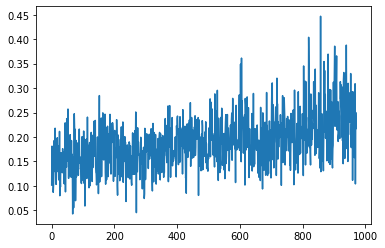

In [ ]:
plt.plot(losses);

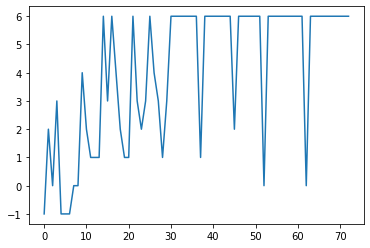

In [ ]:
plt.plot(rewards);

# Save the agent's action as a game log, which is Input for the Demo2 to get a story

In [48]:
test_env = make_env()
test_env = TextWorldPreproc(test_env)
test_agent = DQNAgent(net, prep, epsilon=0, device=device)
total_reward = 0
step_idx = 0
s = test_env.reset()

In [49]:
  
while True:
    step_idx += 1
    actions, _ = test_agent([s])
    action = actions[0]
    action_text = test_env.last_admissible_commands[action]
    s, r, is_done, _ = test_env.step(action)
    print(test_env.last_extra_info)
    f_p.write(str(test_env.last_extra_info))
    total_reward += r
    print("%d: %s -> reward=%s, total_reward=%s" % (step_idx,  action_text, r, total_reward))
    f_p.write("%d: %s -> reward=%s, total_reward=%s" % (step_idx,  action_text, r, total_reward))
    if is_done:
        break

{'description': '-= Cubicle =-\nWell, here we are in the cubicle. You try to gain information on your surroundings by using a technique you call "looking."\n\nYou can see a desk. On the desk you see a folder.\n\nThere is a closed portal leading east. There is an exit to the west. Don\'t worry, it is unblocked.\n\n\n', 'inventory': 'You are carrying:\n  a loaf of bread\n\n\n', 'admissible_commands': ['drop loaf of bread', 'eat loaf of bread', 'examine desk', 'examine folder', 'examine loaf of bread', 'examine portal', 'go west', 'inventory', 'look', 'open portal', 'put loaf of bread on desk', 'take folder from desk'], 'intermediate_reward': 1}
1: go east -> reward=1, total_reward=1
{'description': '-= Cubicle =-\nWell, here we are in the cubicle. You try to gain information on your surroundings by using a technique you call "looking."\n\nYou can see a desk. On the desk you see a folder.\n\nThere is an open portal leading east. There is an exit to the west. Don\'t worry, it is unblocked.

In [50]:
f_t.close()
f_p.close()

In [51]:
with open(file_traininglog,'r') as testwritefile:
    print(testwritefile.read())

28: Done 1 episodes: reward = 1.00, steps = 50, speed = 6.56 steps/sec, epsilon = 0.97 
57: Done 2 episodes: reward = -1.00, steps = 29, speed = 6.42 steps/sec, epsilon = 0.94 
58: Done 3 episodes: reward = -1.00, steps = 1, speed = 4.22 steps/sec, epsilon = 0.94 
108: Done 4 episodes: reward = 2.00, steps = 50, speed = 6.25 steps/sec, epsilon = 0.89 
156: Done 5 episodes: reward = 0.00, steps = 48, speed = 6.17 steps/sec, epsilon = 0.84 
206: Done 6 episodes: reward = 0.00, steps = 50, speed = 6.06 steps/sec, epsilon = 0.80 
256: Done 7 episodes: reward = 3.00, steps = 50, speed = 5.86 steps/sec, epsilon = 0.74 
285: Done 8 episodes: reward = 1.00, steps = 29, speed = 5.59 steps/sec, epsilon = 0.72 
335: Done 9 episodes: reward = 3.00, steps = 50, speed = 5.67 steps/sec, epsilon = 0.67 
358: Done 10 episodes: reward = 1.00, steps = 23, speed = 5.58 steps/sec, epsilon = 0.64 
368: Done 11 episodes: reward = -1.00, steps = 10, speed = 5.50 steps/sec, epsilon = 0.63 
397: Done 12 episode